# 06. 전이학습

전이 학습이란 기존에 학습된 모델의 지식을 가져와 새로운 문제에 적용하는 방법

기존 모델 : 수백만 장의 이미지로 사전 학습된 강력학 모델(ResNet 등)

새로운 문제 : 우리가 다루는 소량의 음식 이미지셋

즉 사전 학습된 모델은 이미지에서 유용한 특징(feature)를 잘 파악하고 있기 때문에, 그 지식을 이전(transfer)하여 새로운 데이터셋에 빠르게 적용할 수 있다. 

전이 학습이 효과적인 이유 

- 대규모 데이터 없어도 좋은 성능을 낼 수 있음
- 학습 시간이 단축됨
- 기존 모델이 이미 좋은 시각적 표현을 학습했기 때문에 빠르게 수렴함

### NLP에서의 전이 학습

언어 모델이 위키피디아 전체를 읽으며 언어 구조와 표현을 학습함

이후 그 모델을 기반으로 감정 분류, 질문 응답 등 다양한 NLP 문제에 적용

**-> 잘 작동하는 사전 학습 모델(pretrained model)을 찾아 이를 우리의 새로운 문제에 맞게 조정(finetuning)해서 사용**


In [1]:

# try-except 문 
# try 부분에서 예외 발생하면 except 부분 실행
# assert 는 이 조건이 참이 아니면 에러를 발생시키는 문 

# torch는 1.12 이상, torchvisiondms 0.13 이상의 버전 필요
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.7.1+cu126
torchvision version: 0.22.1+cu126


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# torchinfo import, 없으면 다운로드
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [5]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

### torchvision.models 용 변환 만들기

사전 학습된 모델을 사용할 때는, 그 모델이 처음 학습된 데이터와 동일한 방식으로 입력 데이터를 전처리해야 한다.

weights를 가져오고 weights.transforms()으로 자동 변환을 가져올 수 있다. 

In [6]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # DEFAULT는 이 모델에서 사용할 수 있는 최상의 성능을 내는 사전 학습 가중치 세트이다. 
auto_transform = weights.transforms()



In [7]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                              test_dir = test_dir,
                                                                              transform = auto_transform,
                                                                              batch_size = 32)

## 3. 어떤 사전학습 모델을 사용하는 것이 좋을까

대표적인 사전학습 모델

- ResNet : torchvision.models.resnet18(), resnet50() 등
- VGG : torchvision.models.vgg16()
- EfficientNet : torchvision.models.efficientnet_b0()
- ViT(Vision Transformer) : torchvision.models.vit_b_16()
- ConvNeXt : torchvison.models.convnext_tiny(), convnext_small() 등

### 전이학습의 핵심 흐름

1. 사전학습된 모델을 불러온다.
2. 마지막 출력층만 현재 문제에 맞게 수정한다.
3. 필요 시 일부 계층은 고정(freeze)하고, 나머지를 훈련시킨다.
4. 훈련된 모델을 사용해 새로운 이미지 분류 문제 해결


In [8]:
# 이전 방식
# model = torchvision.models.efficientnet_b0(pretrained = True).to(device)

# 현재 방식
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device)

In [9]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## torchinfo.summary()란? 
pytorch 모델의 레이어별 입출력 크기, 파라미터 수, 연산량 등을 정리해 보여주는 도구

주요 인자 

- model : 요약하고자 하는 모델 객체
- input_soze : 입력 데이터 형태, 일반적으로 (배치사이즈, 채널, heights, width) 형태
- col_names : 출력 테이블에 포함할 열의 항목들
- col_width : 각 열의 너비
- row_settings : 행별로 표시할 항목(var_names는 레이어 이름 보여줌) 

In [10]:
from torchinfo import summary

summary(model, input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 전이학습에서 필요한 두가지 과정

1. Base 모델의 layer를 Freeze하기

학습 도중 해당 레이어의 가중치가 업데이트되지 않도록 고정하는 것

requires_grad 속성을 False로 설정하기

2. output layer(classifier) 수정하기

ImageNet 데이터셋은 1000개 클래스기이기 때문에 기본 출력이 1000으로 되어 있다. 우리의 새로운 문제는 3가지 클래스만 존재하기 때문에 출력층을 수정해주자.

In [11]:
for param in model.features.parameters():
    param.requires_grad = False

In [12]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace = True),
    torch.nn.Linear(in_features = 1280, out_features = output_shape, bias = True)
).to(device)

In [13]:
summary(model, input_size = (32, 3, 224, 224),
        verbose = 0,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. 모델 학습



In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer 
start_time = timer()

results = engine.train(model = model, 
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer, 
                       loss_fn = loss_fn,
                       epochs = 500,
                       device = device)

end_time = timer()
print(f"전체 학습 시간 : {end_time - start_time:.3f} seconds")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5299 | train_acc: 0.9297 | test_loss: 0.5659 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.4778 | train_acc: 0.9258 | test_loss: 0.5201 | test_acc: 0.8655
Epoch: 3 | train_loss: 0.4519 | train_acc: 0.9219 | test_loss: 0.5223 | test_acc: 0.8551
Epoch: 4 | train_loss: 0.4767 | train_acc: 0.8398 | test_loss: 0.4780 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.4070 | train_acc: 0.9609 | test_loss: 0.4913 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.4383 | train_acc: 0.8203 | test_loss: 0.4694 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.4075 | train_acc: 0.9414 | test_loss: 0.4546 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.4304 | train_acc: 0.8320 | test_loss: 0.4505 | test_acc: 0.8665
Epoch: 9 | train_loss: 0.4999 | train_acc: 0.8242 | test_loss: 0.4429 | test_acc: 0.8352
Epoch: 10 | train_loss: 0.4107 | train_acc: 0.8320 | test_loss: 0.3851 | test_acc: 0.9062
Epoch: 11 | train_loss: 0.3496 | train_acc: 0.9492 | test_loss: 0.4113 | test_acc: 0.8456
Epoch: 12 | train_l

## 손실 함수 곡선을 이용한 모델 평가 


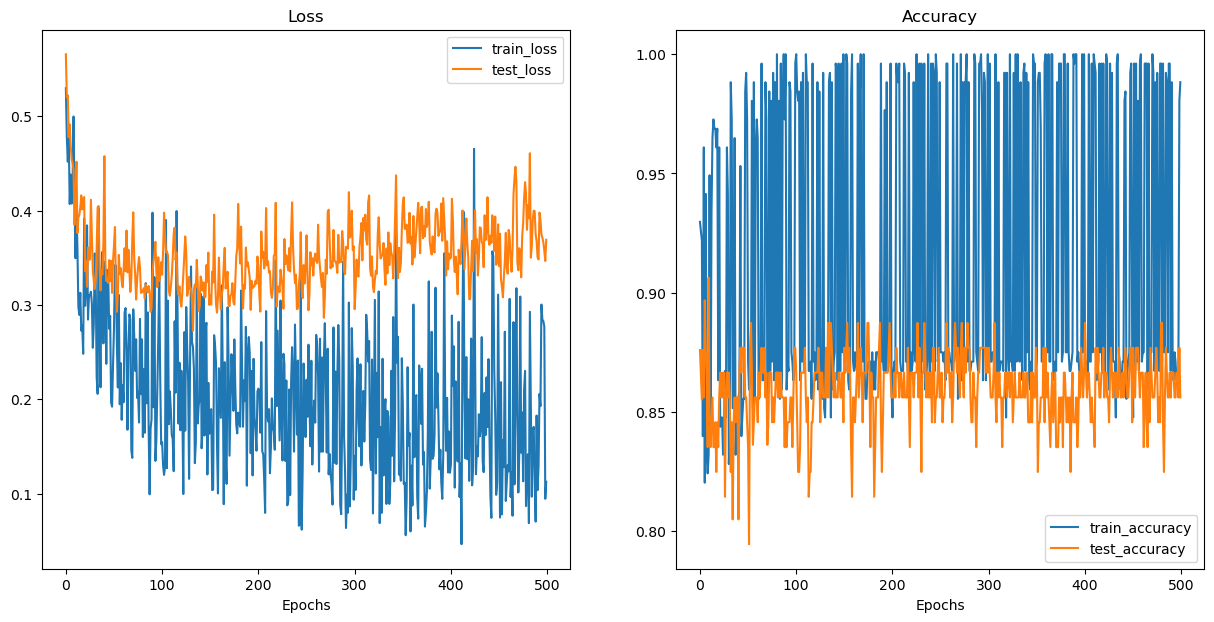

In [17]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)